In [31]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import pickle
from sklearn.metrics import accuracy_score


In [32]:

#======================================================================
# Load the dataset
fields = ['value', 'perf']
data_attack1 = pd.read_csv('../data_proc/data_attack1.csv', skipinitialspace=True, usecols=fields, sep = ", ", engine='python')
data_normal1 = pd.read_csv('../data_proc/data_normal1.csv', skipinitialspace=True, usecols=fields, sep = ", ", engine='python')
print(data_attack1.head(6))


      value              perf
0     11669      cache-misses
1  35833832  cache-references
2  38563089         ldst_spec
3     11559      cache-misses
4  35975989  cache-references
5  38525707         ldst_spec


In [33]:
fields = ['value', 'perf']

data_safe_attack1 = pd.read_csv('../data_proc/data_safe_attack1.csv', skipinitialspace=True, usecols=fields, sep = ", ", engine='python')
data_safe1 = pd.read_csv('../data_proc/data_safe1.csv', skipinitialspace=True, usecols=fields, sep = ", ", engine='python')

data_attack = pd.read_csv('../data_proc/data_attack2.csv', skipinitialspace=True, usecols=fields, sep = ", ", engine='python')
data_normal2 = pd.read_csv('../data_proc/data_normal2.csv', skipinitialspace=True, usecols=fields, sep = ", ", engine='python')
data_safe_attack2 = pd.read_csv('../data_proc/data_safe_attack2.csv', skipinitialspace=True, usecols=fields, sep = ", ", engine='python')
data_safe2 = pd.read_csv('../data_proc/data_safe2.csv', skipinitialspace=True, usecols=fields, sep = ", ", engine='python')

data_attack3 = pd.read_csv('../data_proc/data_attack3.csv', skipinitialspace=True, usecols=fields, sep = ", ", engine='python')
data_normal3 = pd.read_csv('../data_proc/data_normal3.csv', skipinitialspace=True, usecols=fields, sep = ", ", engine='python')
data_safe_attack3 = pd.read_csv('../data_proc/data_safe_attack3.csv', skipinitialspace=True, usecols=fields, sep = ", ", engine='python')
data_safe3 = pd.read_csv('../data_proc/data_safe3.csv', skipinitialspace=True, usecols=fields, sep = ", ", engine='python')

#frames = [data_normal3, data_safe_attack3, data_safe3, data_attack2, data_normal2, data_safe_attack2, data_safe2, data_attack2, data_normal2, data_safe_attack2, data_safe2]
frames = [data_normal2, data_safe_attack2, data_safe2, data_attack1, data_normal1, data_safe_attack1, data_safe1, data_attack3, data_normal3, data_safe_attack3, data_safe3]

#print(data_attack.shape,normal_2.shape, attack_2.shape,data_normal.shape, attack_3.shape, normal_3.shape)
#print(data_attack3.shape[0])


In [34]:
#pd.set_option('display.max_colwidth', None)
#c = 'perf'
#print(data_attack1)
#print(data_attack)
#data_new = data_attack.set_index([data_attack.groupby(c).cumcount() + 1, c]).unstack().sort_index(1, 1)
#data_new.columns = data_new.columns.droplevel(0)
#data_new['y'] = np.zeros([data_new.shape[0],1],dtype=int)
#print(data_new)

In [35]:
pd.set_option('display.max_colwidth', None)
c = 'perf'
data_new = data_attack.set_index([data_attack.groupby(c).cumcount() + 1, c]).unstack().sort_index(1, 1)
data_new.columns = data_new.columns.droplevel(0)
data_new['y'] = np.zeros([data_new.shape[0],1],dtype=int)
for df in data_new.drop(['y'],axis=1):
    q_low = data_new[df].quantile(0.01)
    q_hi  = data_new[df].quantile(0.99)
    data_new = data_new[(data_new[df]< q_hi) & (data_new[df] > q_low)]
#data_new['br_miss_rate']=data_new['armv8_cortex_a72/br_mis_pred/'].truediv(data_new['armv8_cortex_a72/br_pred/'])
data_new['cache_miss_rate']=data_new['cache-misses'].mul(100).truediv(data_new['cache-references'])
data_new['spec_load'] = data_new['ldst_spec'].truediv(data_new['ldst_spec'].max())
print(data_new.shape[0])
i = 1
for frame in frames:
    temp = frame.set_index([frame.groupby(c).cumcount() + 1, c]).unstack().sort_index(1, 1)
    #data_normal_new = data_normal.set_index([data_normal.groupby(c).cumcount() + 1, c]).unstack().sort_index(1, 1)
    temp.columns = temp.columns.droplevel(0)
    if i%4 == 0: #TODO fix this logic
        temp['y'] = np.zeros([temp.shape[0],1],dtype=int)
        #print(temp)
    elif i%4 ==1:
        temp['y'] = np.ones([temp.shape[0],1],dtype=int)
    elif i%4 ==2:
        temp['y'] = np.full([temp.shape[0],1],2,dtype=int)
    elif i%4 ==3:
        temp['y'] = np.full([temp.shape[0],1],3,dtype=int)
    for df in temp.drop(['y'],axis=1):
        q_low = temp[df].quantile(0.01)
        q_hi  = temp[df].quantile(0.99)
        temp = temp[(temp[df]< q_hi) & (temp[df] > q_low)]
    #temp['br_miss_rate']=temp['armv8_cortex_a72/br_mis_pred/'].truediv(temp['armv8_cortex_a72/br_pred/'])
    temp['cache_miss_rate']=temp['cache-misses'].mul(100).truediv(temp['cache-references'])
    
    data_new = pd.concat([data_new,temp],axis=0)
    print(data_new.shape[0], " ", i%4, "blocksize",temp.shape[0])
    i=i+1

data_new = data_new.dropna(axis=1, how='all')
data_new.to_csv('intermed', sep=';')
    #data_new.tail()
#data_new.columns = data_new.columns.droplevel(0)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(data_new)

C:\Users\Sirius\AppData\Local\Temp/ipykernel_9080/3899989204.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_index will be keyword-only
  data_new = data_attack.set_index([data_attack.groupby(c).cumcount() + 1, c]).unstack().sort_index(1, 1)
C:\Users\Sirius\AppData\Local\Temp/ipykernel_9080/3899989204.py:16: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_index will be keyword-only
  temp = frame.set_index([frame.groupby(c).cumcount() + 1, c]).unstack().sort_index(1, 1)


1010
1957   1 blocksize 947
2907   2 blocksize 950
3857   3 blocksize 950
4906   0 blocksize 1049
5861   1 blocksize 955
6821   2 blocksize 960
7980   3 blocksize 1159
8939   0 blocksize 959
9890   1 blocksize 951
10841   2 blocksize 951
11810   3 blocksize 969
perf  cache-misses  cache-references  ldst_spec  y  cache_miss_rate  spec_load
1            64400          91904027   97449245  0         0.070073   0.968603
2            64794          92913714   98444548  0         0.069736   0.978496
3            64626          92817684   98593139  0         0.069627   0.979973
4            64829          92616024   98125177  0         0.069998   0.975322
5            64635          92881996   98547410  0         0.069588   0.979519
6            64520          92910948   98527346  0         0.069443   0.979319
7            64197          92367780   98215278  0         0.069502   0.976217
8            64616          92976267   98681265  0         0.069497   0.980849
9            64646         

In [36]:
# Remove outliers
print(data_new.shape)
#for df in data_new.drop(['y'],axis=1):
#    q_low = data_new[df].quantile(0.01)
#    q_hi  = data_new[df].quantile(0.99)
#    data_new = data_new[(data_new[df]< q_hi) & (data_new[df] > q_low)]
#print(data_new.shape)
#TODO fix this unused
#for df in data_normal_new:
#    q_low = data_normal_new[df].quantile(0.01)
#    q_hi  = data_normal_new[df].quantile(0.99)
#    data_normal_new = data_normal_new[(data_normal_new[df]< q_hi) & (data_normal_new[df] > q_low)]

(11810, 6)


Removed the outliars from the data
Calculate br_miss_rate, cache_miss_rate, relative_spec_load

In [37]:
# create 3 new features branch miss rate, cache miss rate, spec load
#data_new['br_miss_rate']=data_new['armv8_cortex_a72/br_mis_pred/'].truediv(data_new['armv8_cortex_a72/br_pred/'])
#data_new['cache_miss_rate']=data_new['cache-misses'].mul(100).truediv(data_new['cache-references'])
#data_new['spec_load'] = data_new['ldst_spec'].truediv(data_new['ldst_spec'].max())

#data_normal_new['br_miss_rate']=data_normal_new['armv8_cortex_a72/br_mis_pred/'].truediv(data_normal_new['armv8_cortex_a72/br_pred/'])
#data_normal_new[('cache_miss_rate')]=data_normal_new[('cache-misses')].mul(100).truediv(data_normal_new[('cache-references')])
#data_normal_new[('spec_load')] = data_normal_new[('ldst_spec')].truediv(data_normal_new[('ldst_spec')].max())

scaler = MinMaxScaler()
#data_new['br_miss_rate'] = scaler.fit_transform(data_new['br_miss_rate'].values.reshape(-1,1))
#data_new['cache_miss_rate'] = scaler.fit_transform(data_new['cache_miss_rate'].values.reshape(-1,1))
#data_new['ldst_spec'] = scaler.fit_transform(data_new['ldst_spec'].values.reshape(-1,1))

#data_normal_new['br_miss_rate'] = scaler.fit_transform(data_normal_new['br_miss_rate'].values.reshape(-1,1))
#data_normal_new['cache_miss_rate'] = scaler.fit_transform(data_normal_new['cache_miss_rate'].values.reshape(-1,1))
#data_normal_new['ldst_spec'] = scaler.fit_transform(data_normal_new['ldst_spec'].values.reshape(-1,1))

print(data_new.head)

<bound method NDFrame.head of perf  cache-misses  cache-references  ldst_spec  y  cache_miss_rate  spec_load
1            64400          91904027   97449245  0         0.070073   0.968603
2            64794          92913714   98444548  0         0.069736   0.978496
3            64626          92817684   98593139  0         0.069627   0.979973
4            64829          92616024   98125177  0         0.069998   0.975322
5            64635          92881996   98547410  0         0.069588   0.979519
...            ...               ...        ... ..              ...        ...
1029          2066          24360164   25736697  3         0.008481        NaN
1030          1952          24316761   25691247  3         0.008027        NaN
1031          1955          24309963   25727784  3         0.008042        NaN
1032          1945          24352456   25750073  3         0.007987        NaN
1033          1923          24499191   25850586  3         0.007849        NaN

[11810 rows x 6 colum

3016 2850 2858 3075


<AxesSubplot:ylabel='Frequency'>

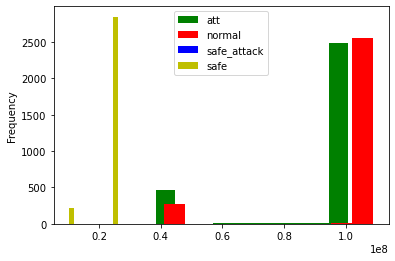

In [38]:
att = data_new[:1010].append(data_new[3858:4906]).append(data_new[7981:8939])
norm = data_new[1011:1957].append(data_new[4907:5861]).append(data_new[8940:9890])
sa = data_new[1958:2907].append(data_new[5862:6821]).append(data_new[9891:10841])
s = data_new[2908:3857].append(data_new[6822:7980]).append(data_new[10842:11810])
#att = data_new[:750].append(data_new[3553:4135   ]).append(data_new[6725:7307])
#norm = data_new[751:1631   ].append(data_new[4136:4997   ]).append(data_new[7308:8169   ])
#sa = data_new[1632:2658   ].append(data_new[4998:5902   ]).append(data_new[8170:9074   ])
#s = data_new[2659:3552   ].append(data_new[5903:6724   ]).append(data_new[9075:9896      ])
print(att.shape[0], norm.shape[0], sa.shape[0], s.shape[0])
att[('ldst_spec')].plot.hist(label='att',color="g",legend=True)
norm[('ldst_spec')].plot.hist(label='normal', color="r",legend=True)
sa[('ldst_spec')].plot.hist(label='safe_attack', color="b",legend=True)
s[('ldst_spec')].plot.hist(label='safe', color="y",legend=True)

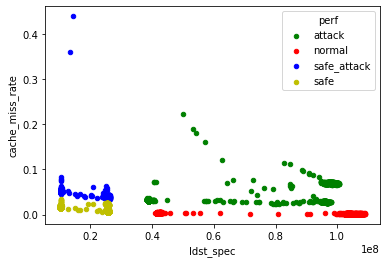

In [39]:
ax =att.plot.scatter(x='ldst_spec', y='cache_miss_rate', color="g", label='attack',legend=True)
X= norm.plot.scatter(x='ldst_spec',y='cache_miss_rate', color="r",label='normal',legend=True,ax=ax)
X= sa.plot.scatter(x='ldst_spec',y='cache_miss_rate', color="b",label='safe_attack',legend=True,ax=X)
X= s.plot.scatter(x='ldst_spec',y='cache_miss_rate', color="y",label='safe',legend=True,ax=X)

#ax =att.plot.scatter(x='br_miss_rate', y='cache_miss_rate', color="g", label='att',legend=True)
#X= norm.plot.scatter(x='br_miss_rate',y='cache_miss_rate', color="r",label='normal',legend=True,ax=ax)
#X= sa.plot.scatter(x='br_miss_rate',y='cache_miss_rate', color="b",label='safe_attack',legend=True,ax=X)
#X= s.plot.scatter(x='br_miss_rate',y='cache_miss_rate', color="y",label='safe',legend=True,ax=X)
#ax =att.plot.scatter(x='br_miss_rate', color="g",y='spec_load',legend=True)
#X= norm.plot.scatter(x='br_miss_rate',y='spec_load', color="r",legend=True,ax=ax)

In [40]:
#data_normal_new[('cache_miss_rate')].plot(label='cache_miss_rate',legend=True)
#data_normal_new[('br_miss_rate')].plot(label='br_miss_rate_N',legend=True)
#data_normal_new[('spec_load')].plot(label='spec_load',legend=True)
#data_new[('cache_miss_rate')].plot(label='cache_miss_rate',legend=True)
#data_new[('br_miss_rate')].plot(label='br_miss_rate_A',legend=True)
#att = data_new[:1215]
#norm = data_new[13000:]

#print(data_new[3900:])
#ax=att.plot.scatter(x='br_miss_rate',y='cache_miss_rate', color="r", legend=True)
#norm.plot.scatter(x='br_miss_rate',y='cache_miss_rate', color="g", legend=True,ax=ax)

In [41]:
from sklearn import svm, datasets
import sklearn.model_selection as model_selection
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.multiclass import OneVsOneClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression


data_train = data_new[['cache_miss_rate','ldst_spec']]
y_train = data_new['y']
print(y_train)
print(data_train)

X_train, X_test, y_train, y_test = model_selection.train_test_split(data_train, y_train, train_size=0.80, test_size=0.20, random_state=9221215)




1       0
2       0
3       0
4       0
5       0
       ..
1029    3
1030    3
1031    3
1032    3
1033    3
Name: y, Length: 11810, dtype: int32
perf  cache_miss_rate  ldst_spec
1            0.070073   97449245
2            0.069736   98444548
3            0.069627   98593139
4            0.069998   98125177
5            0.069588   98547410
...               ...        ...
1029         0.008481   25736697
1030         0.008027   25691247
1031         0.008042   25727784
1032         0.007987   25750073
1033         0.007849   25850586

[11810 rows x 2 columns]


In [42]:
from sklearn.multiclass import OneVsRestClassifier
from xgboost import XGBClassifier
# define model
model = OneVsOneClassifier(XGBClassifier(n_jobs=-1, max_depth=4))
#model = SVC(decision_function_shape='ovo')

# fit model
clf = model.fit(X_train, y_train)

print(data_train)


filename = 'finalized_model_multi_class_ovo.sav'
pickle.dump(clf, open(filename, 'wb'))

[12:45:54] WARNING: D:\bld\xgboost-split_1643227225381\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

D:\Installed_soft\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Installed_soft\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Installed_soft\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBC


[12:45:54] WARNING: D:\bld\xgboost-split_1643227225381\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:45:54] WARNING: D:\bld\xgboost-split_1643227225381\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:45:54] WARNING: D:\bld\xgboost-split_1643227225381\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:45:54] WARNING: D:\bld\xgboost-split_1643227225381\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation m

D:\Installed_soft\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Installed_soft\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Installed_soft\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBC

Training set score for SVM: 1.000000
Testing  set score for SVM: 1.000000


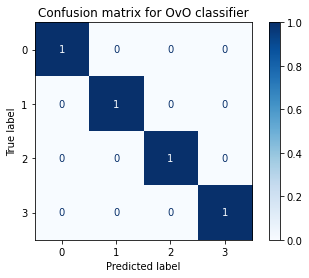

D:\Installed_soft\lib\site-packages\mlxtend\plotting\decision_regions.py:274: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x=x_data,


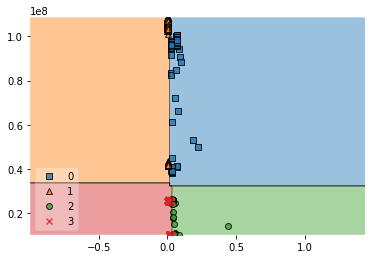

In [43]:
# Predict
loaded_model = pickle.load(open(filename, 'rb'))

Y_pred = loaded_model.predict(X_test)

print("Training set score for SVM: %f" % loaded_model.score(X_train , y_train))
print("Testing  set score for SVM: %f" % loaded_model.score(X_test  , y_test ))

from sklearn.metrics import plot_confusion_matrix
from mlxtend.plotting import plot_decision_regions
# Evaluate by means of a confusion matrix
matrix = plot_confusion_matrix(loaded_model, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize='true')
plt.title('Confusion matrix for OvO classifier')
plt.show(matrix)
plt.show()

# Plot decision boundary
plot_decision_regions(X_test.values, y_test.values, clf=loaded_model, legend=3)
plt.show()